# HOMEWORK 6: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming) 

In this homework, you are asked to do the following tasks:
1. Data Cleaning
2. Preprocessing data for pytorch
3. Build and evaluate a model for "action" classification
4. Build and evaluate a model for "object" classification
5. Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 


Note: we have removed phone numbers from the dataset for privacy purposes. 

In [1]:
!wget --no-check-certificate https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv

--2023-02-25 04:16:21--  https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv [following]
--2023-02-25 04:16:22--  https://www.dropbox.com/s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc10b4ead02baa8197417f6ba57b.dl.dropboxusercontent.com/cd/0/inline/B3Ka2b6JX71WrsacavSLrKmNu0W1EkfU5uDqEedWXedhDYOCiUNMyS3jVlUSmLNojMqsei_Al9qUqUcJXqqnEqg1dqccjy2dsubJXWEQ596clic39lb2A8yQAfK_TvBoOvtTXVl-F2zE7547MSIfC6ZodgdqhG-yH_ZI4_3cr-7TYg/file# [following]
--2023-02-25 04:16:22--  https://uc10b4ead02baa8197417f6ba57b.dl.dropboxusercontent.com/cd/0/inline/B3Ka2b6JX71Wrsaca

In [2]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libs

In [3]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd 

from torch.utils.data import Dataset
from IPython.display import display
from pythainlp.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [4]:
data_df = pd.read_csv('clean-phone-data-for-students.csv')

Let's preview the data.

In [5]:
# Show the top 5 rows
display(data_df.head())
# Summarize the data
data_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 1: 
You will have to remove unwanted label duplications as well as duplications in text inputs. 
Also, you will have to trim out unwanted whitespaces from the text inputs. 
This shouldn't be too hard, as you have already seen it in the demo.



In [6]:
display(data_df.describe())
display(data_df.Object.unique())
display(data_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

In [7]:
# TODO1: Data cleaning
data_df['action_label']=data_df['Action'].str.lower().copy()
data_df['object_label']=data_df['Object'].str.lower().copy()
data_df.drop('Action', axis=1, inplace=True)
data_df.drop('Object', axis=1, inplace=True)
data_df.drop_duplicates('Sentence Utterance', inplace=True)
display(data_df.describe())
display(data_df.action_label.unique())
display(data_df.object_label.unique())

,Sentence Utterance,action_label,object_label
count,13389,13389,13389
unique,13389,8,26
top,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,service
freq,1,8658,2111


array(['enquire', 'report', 'cancel', 'buy', 'activate', 'request',
       'garbage', 'change'], dtype=object)

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

In [8]:
def strip_str(string):
    return string.strip()
data = data_df.to_numpy()

print("Before")
print(data[:,0])
data[:,0] = np.vectorize(strip_str)(data[:,0])
print("After")
print(data[:,0])

Before
[' <PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท'
 ' internet ยังความเร็วอยุ่เท่าไหร ครับ'
 ' ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ' ...
 'ยอดเงินเหลือเท่าไหร่ค่ะ' 'ยอดเงินในระบบ'
 'สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ']
After
['<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท'
 'internet ยังความเร็วอยุ่เท่าไหร ครับ'
 'ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ' ...
 'ยอดเงินเหลือเท่าไหร่ค่ะ' 'ยอดเงินในระบบ'
 'สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ']


## TODO2 : Assign index to word and labels in each sentences. 

Note that please use **word_tokenize** (https://pythainlp.github.io/docs/2.0/api/tokenize.html) as a function to tokenize each sentences.

In [9]:
# TODO2: assign index to each words and labels in sentence. 

# assign index to labels
unique_action = data_df.action_label.unique()
unique_object = data_df.object_label.unique()

action_2_num_map = dict(zip(unique_action, range(len(unique_action))))
num_2_action = dict(zip(range(len(unique_action)), unique_action))
data[:,1] = np.vectorize(action_2_num_map.get)(data[:,1])

object_2_num_map = dict(zip(unique_object, range(len(unique_object))))
num_2_object = dict(zip(range(len(unique_object)), unique_object))
data[:,2] = np.vectorize(object_2_num_map.get)(data[:,2])


In [10]:
# assign index to words
from pythainlp.tokenize import word_tokenize
data[:,0] = np.array([word_tokenize(sentence, engine="newmm") for sentence in data[:,0]], dtype='object')

word_2_idx = {}
idx_2_word = {}
for tokens in data[:,0]:
  for word in tokens:
    if word not in word_2_idx:
      word_2_idx[word] = len(word_2_idx)+1
      idx_2_word[len(word_2_idx)] = word
word_2_idx['UNK'] = len(word_2_idx)+1
idx_2_word[len(word_2_idx)] = 'UNK'
data[:,0] = np.array([ np.array([word_2_idx[word] for word in tokens]) for tokens in data[:,0]], dtype='object')

In [11]:
idx = np.random.randint(data.shape[0])
print(f'sequence len: {len(data[idx,0])}, action: {data[idx,1]}, object: {data[idx,2]}')

sequence len: 6, action: 7, object: 1


In [12]:
X = data[:,0]
ys = data[:,1:].astype('int64')

In [13]:
# Pad the sequence length of X to be maxlen 
import torch 
from torch.nn.utils.rnn import pad_sequence

X = [torch.LongTensor(x) for x in X]

X = pad_sequence(X, batch_first=True).numpy()

maxlen = X.shape[1]

## TODO 2,3: Preprocessing data for pytorch
You will be using pytorch in this assignment. Please show us how you prepare your dataloader for pytorch.
Don't forget to split data into train, valdation, and test sets (normally the ratio will be 80:10:10 , respectively)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [15]:
import pandas as pd
from IPython.display import display
import pandas as pd

# for validation part 
def categorical_accuracy(preds, y):
  preds = preds.argmax(dim=1).numpy()
  y = y.numpy()
  return accuracy_score(y, preds)

def categorical_f1(preds, y):
  preds = preds.argmax(dim=1).numpy()
  y = y.numpy()
  return f1_score(y, preds, average='weighted')


In [16]:
# TODO2: Preprocessing data for pytorch 
class TrueCallCenterDataset(Dataset):
  def __init__(self, data, labels=None):
    self.data = data
    self.labels = labels

    if labels is not None: 
      assert len(data) == len(labels)  

  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, idx):
    if self.labels is None: 
      return torch.LongTensor(self.data[idx])
    else: 
      return (
          torch.LongTensor(self.data[idx]), 
          torch.LongTensor([self.labels[idx]])
      )


## TODO 3: Split the data

We recommend to use train_test_spilt from scikit-learn to split the data into train, validation, test set. 

In addition, it should split the data that distribution of the labels in train , validation, test set are similar. There is **stratify** variable handling this issue. 

In this case, you can choose whatever you want either "**Action**" or "**Object**" ;). 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [17]:
# TODO3: split data into train, validation, test  
from sklearn.model_selection import train_test_split
X_train, X_test, ys_train, ys_test = train_test_split(X, ys, test_size=0.1, stratify=ys[:,0])
X_train, X_val, ys_train, ys_val = train_test_split(X_train, ys_train, test_size=X_test.shape[0]/X_train.shape[0], stratify=ys_train[:,0])

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, X_val: {X_val.shape}')
print(f'ys_train: {ys_train.shape}, ys_test: {ys_test.shape}, ys_val: {ys_val.shape}')

X_train: (10711, 131), X_test: (1339, 131), X_val: (1339, 131)
ys_train: (10711, 2), ys_test: (1339, 2), ys_val: (1339, 2)


## TODO 4: Build a model for classifying these texts.


In [18]:
!pip install torchinfo 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import torchinfo 
from torch import nn 
from torch.nn import Embedding, Dropout, GRU, LSTM, Linear, CrossEntropyLoss
from torch.optim import Adam
import torch.nn.functional as F

class Encoder(nn.Module):
  def __init__(self, word_2_idx, embedding_dim=48, _weight=None):
    super(Encoder, self).__init__() 
    self.embed = Embedding(len(word_2_idx), embedding_dim, padding_idx=0, _weight=_weight)
  def forward(self, x):
    x = self.embed(x)
    return x

class Classifier(nn.Module):
  def __init__(self, num_classes, embedding_dim=48):
    super(Classifier, self).__init__() 
    self.ff = Linear(embedding_dim, 32) 
    self.classifier = Linear(32, len(num_classes))
  def forward(self, x):
    x = self.ff(x)
    x = self.classifier(x)
    return x

class Model(nn.Module):
  def __init__(self, encoder, classifier_1, classifier_2=None):
    super().__init__()
    self.encoder = encoder
    self.classifier_1 = classifier_1
    self.classifier_2 = classifier_2
  def forward(self,x):
    x = self.encoder(x)

    mask = (x!=0)
    x = (x*mask).sum(dim=1)/mask.sum(dim=1)

    out_1 = self.classifier_1(x)
    if self.classifier_2 == None:
      return out_1 
    else:
      out_2 = self.classifier_2(x)
      return (out_1, out_2)

## #TODO 3: Build and evaluate a model for "action" classification


In [20]:
## TODO 3.1: prepare dataloader
train_action_dataset = TrueCallCenterDataset(X_train, ys_train[:,0]) 
val_action_dataset = TrueCallCenterDataset(X_val, ys_val[:,0])
test_action_dataset = TrueCallCenterDataset(X_test)

num_workers = 2
batch_size = 64

train_action_dataloader = DataLoader(train_action_dataset, batch_size=64, shuffle=True) 
val_action_dataloader = DataLoader(val_action_dataset, batch_size=64, shuffle=False) 
test_action_dataloader = DataLoader(test_action_dataset, batch_size=64, shuffle=False) 

In [21]:
## TODO 3.2: setup model 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_action = Model(encoder = Encoder(word_2_idx), classifier_1 = Classifier(unique_action)) 
model_action.to(device) 

optimizer = Adam(model_action.parameters(), lr=1e-3) 
criterion = CrossEntropyLoss()
print(torchinfo.summary(model_action))

Layer (type:depth-idx)                   Param #
Model                                    --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    199,728
├─Classifier: 1-2                        --
│    └─Linear: 2-2                       1,568
│    └─Linear: 2-3                       264
Total params: 201,560
Trainable params: 201,560
Non-trainable params: 0


In [22]:
from tqdm import tqdm

In [23]:
## TODO 3.3: training loop
num_epochs = 20

train_action_losses = [] 
train_action_accs = [] 

val_action_losses = [] 
val_action_accs = [] 

for epoch in range(1, num_epochs+1): 

  train_minibatch_losses = []

  train_preds = []
  train_targets = []

  model_action.train() 
  for inputs, targets in tqdm(train_action_dataloader):
    optimizer.zero_grad() 

    inputs, targets = inputs.to(device), targets.to(device)

    pred = model_action(inputs)
    
    targets = targets.reshape(-1)

    loss = criterion(pred, targets) 

    train_minibatch_losses.append(loss.item())

    train_preds.append(pred)
    train_targets.append(targets)
    
    loss.backward() 
    optimizer.step()

  val_minibatch_losses = []

  val_preds = []
  val_targets = []

  model_action.eval() 
  for inputs, vals in tqdm(val_action_dataloader): 
    inputs, vals = inputs.to(device), vals.to(device)
    with torch.no_grad(): 
      pred = model_action(inputs)

      pred = pred.reshape(-1, pred.size(-1))
      vals = vals.reshape(-1)
      

      loss = criterion(pred, vals) 

      val_minibatch_losses.append(loss.item())

      val_preds.append(pred)
      val_targets.append(vals)
      
  train_preds = torch.cat(train_preds)
  train_targets = torch.cat(train_targets)
  val_preds = torch.cat(val_preds)
  val_targets = torch.cat(val_targets)

  train_action_losses.append(np.mean(train_minibatch_losses))
  train_action_accs.append(categorical_accuracy(train_preds, train_targets))
  val_action_losses.append(np.mean(val_minibatch_losses))
  val_action_accs.append(categorical_accuracy(val_preds, val_targets))

  print(f' \
    epoch = {epoch:02d},\
    training loss   = {train_action_losses[-1]:.3f}, \
    training acc    = {train_action_accs[-1]:.3f}, \
    validation loss = {val_action_losses[-1]:.3f}, \
    validation acc  = {val_action_accs[-1]:.3f}')
       

100%|██████████| 21/21 [00:00<00:00, 292.01it/s]


     epoch = 01,    training loss   = 1.395,     training acc    = 0.592,     validation loss = 1.067,     validation acc  = 0.672


100%|██████████| 21/21 [00:00<00:00, 542.61it/s]


     epoch = 02,    training loss   = 0.891,     training acc    = 0.713,     validation loss = 0.770,     validation acc  = 0.757


100%|██████████| 21/21 [00:00<00:00, 570.36it/s]


     epoch = 03,    training loss   = 0.679,     training acc    = 0.784,     validation loss = 0.651,     validation acc  = 0.794


100%|██████████| 21/21 [00:00<00:00, 445.42it/s]


     epoch = 04,    training loss   = 0.586,     training acc    = 0.814,     validation loss = 0.599,     validation acc  = 0.805


100%|██████████| 21/21 [00:00<00:00, 537.47it/s]


     epoch = 05,    training loss   = 0.530,     training acc    = 0.830,     validation loss = 0.563,     validation acc  = 0.816


100%|██████████| 21/21 [00:00<00:00, 573.10it/s]


     epoch = 06,    training loss   = 0.492,     training acc    = 0.842,     validation loss = 0.541,     validation acc  = 0.827


100%|██████████| 21/21 [00:00<00:00, 313.66it/s]


     epoch = 07,    training loss   = 0.463,     training acc    = 0.852,     validation loss = 0.524,     validation acc  = 0.824


100%|██████████| 21/21 [00:00<00:00, 319.22it/s]


     epoch = 08,    training loss   = 0.439,     training acc    = 0.857,     validation loss = 0.517,     validation acc  = 0.826


100%|██████████| 21/21 [00:00<00:00, 474.65it/s]


     epoch = 09,    training loss   = 0.421,     training acc    = 0.865,     validation loss = 0.505,     validation acc  = 0.830


100%|██████████| 21/21 [00:00<00:00, 529.00it/s]


     epoch = 10,    training loss   = 0.401,     training acc    = 0.871,     validation loss = 0.504,     validation acc  = 0.833


100%|██████████| 21/21 [00:00<00:00, 531.75it/s]


     epoch = 11,    training loss   = 0.385,     training acc    = 0.876,     validation loss = 0.499,     validation acc  = 0.830


100%|██████████| 21/21 [00:00<00:00, 202.07it/s]


     epoch = 12,    training loss   = 0.369,     training acc    = 0.880,     validation loss = 0.494,     validation acc  = 0.837


100%|██████████| 21/21 [00:00<00:00, 244.86it/s]


     epoch = 13,    training loss   = 0.356,     training acc    = 0.886,     validation loss = 0.492,     validation acc  = 0.832


100%|██████████| 21/21 [00:00<00:00, 338.07it/s]


     epoch = 14,    training loss   = 0.344,     training acc    = 0.890,     validation loss = 0.492,     validation acc  = 0.836


100%|██████████| 21/21 [00:00<00:00, 219.44it/s]


     epoch = 15,    training loss   = 0.331,     training acc    = 0.893,     validation loss = 0.494,     validation acc  = 0.836


100%|██████████| 21/21 [00:00<00:00, 298.61it/s]


     epoch = 16,    training loss   = 0.321,     training acc    = 0.898,     validation loss = 0.497,     validation acc  = 0.839


100%|██████████| 21/21 [00:00<00:00, 254.75it/s]


     epoch = 17,    training loss   = 0.309,     training acc    = 0.902,     validation loss = 0.499,     validation acc  = 0.838


100%|██████████| 21/21 [00:00<00:00, 95.67it/s] 


     epoch = 18,    training loss   = 0.301,     training acc    = 0.903,     validation loss = 0.503,     validation acc  = 0.836


100%|██████████| 21/21 [00:00<00:00, 314.09it/s]


     epoch = 19,    training loss   = 0.292,     training acc    = 0.906,     validation loss = 0.509,     validation acc  = 0.834


100%|██████████| 21/21 [00:00<00:00, 187.19it/s]

     epoch = 20,    training loss   = 0.281,     training acc    = 0.909,     validation loss = 0.515,     validation acc  = 0.830


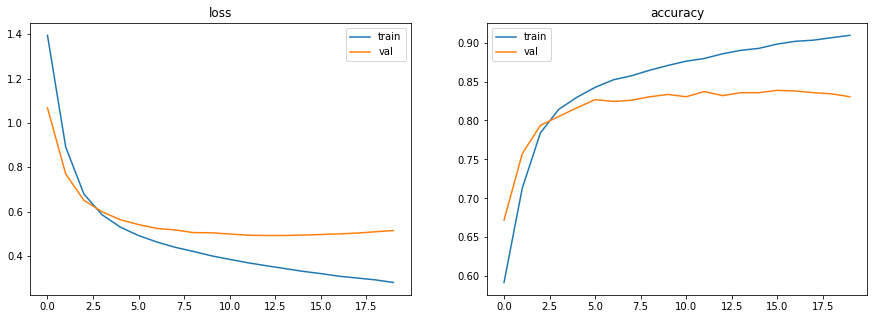

In [24]:
## TODO 3.4: visualize peformance on train , validation set
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.arange(len(train_action_losses)), train_action_losses)
plt.plot(np.arange(len(val_action_losses)), val_action_losses)
plt.legend(['train', 'val'])
plt.title('loss')
plt.subplot(122)
plt.plot(np.arange(len(train_action_accs)), train_action_accs)
plt.plot(np.arange(len(val_action_accs)), val_action_accs)
plt.legend(['train', 'val'])
plt.title('accuracy')
plt.show()

In [25]:
## TODO 3.5: evalaute on test set  
test_preds = []
model_action.eval() 
for inputs in test_action_dataloader: 
  inputs = inputs.to(device)
  with torch.no_grad(): 
    pred = model_action(inputs)
    test_preds.append(pred)
  
test_preds = torch.cat(test_preds)
test_targets = torch.DoubleTensor(ys_test[:,0])
test_acc = categorical_accuracy(test_preds, test_targets)
test_f1 = categorical_f1(test_preds, test_targets)
print(f"test accuracy: {test_acc}")
print(f"test f1      : {test_f1}")

test accuracy: 0.8461538461538461
test f1      : 0.8391541666588023


## #TODO 4: Build and evaluate a model for "object" classification



In [26]:
## TODO 4.1: prepare dataloader 

train_object_dataset = TrueCallCenterDataset(X_train, ys_train[:,1]) 
val_object_dataset = TrueCallCenterDataset(X_val, ys_val[:,1])
test_object_dataset = TrueCallCenterDataset(X_test)

num_workers = 2
batch_size = 64

train_object_dataloader = DataLoader(train_object_dataset, batch_size=64, shuffle=True) 
val_object_dataloader = DataLoader(val_object_dataset, batch_size=64, shuffle=False) 
test_object_dataloader = DataLoader(test_object_dataset, batch_size=64, shuffle=False) 

In [27]:
## TODO 4.2: setup model 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_object = Model(encoder = Encoder(word_2_idx), classifier_1 = Classifier(unique_object)) 
model_object.to(device) 

optimizer = Adam(model_object.parameters(), lr=1e-3) 
criterion = CrossEntropyLoss()
print(torchinfo.summary(model_object))

Layer (type:depth-idx)                   Param #
Model                                    --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    199,728
├─Classifier: 1-2                        --
│    └─Linear: 2-2                       1,568
│    └─Linear: 2-3                       858
Total params: 202,154
Trainable params: 202,154
Non-trainable params: 0


In [28]:
## TODO 4.3: training loop
num_epochs = 20

train_object_losses = [] 
train_object_accs = [] 

val_object_losses = [] 
val_object_accs = [] 

for epoch in range(1, num_epochs+1): 

  train_minibatch_losses = []

  train_preds = []
  train_targets = []

  model_object.train() 
  for inputs, targets in tqdm(train_object_dataloader):
    optimizer.zero_grad() 

    inputs, targets = inputs.to(device), targets.to(device)

    pred = model_object(inputs)
    
    targets = targets.reshape(-1)

    loss = criterion(pred, targets) 

    train_minibatch_losses.append(loss.item())

    train_preds.append(pred)
    train_targets.append(targets)
    
    loss.backward() 
    optimizer.step()

  val_minibatch_losses = []

  val_preds = []
  val_targets = []

  model_object.eval() 
  for inputs, vals in tqdm(val_object_dataloader): 
    inputs, vals = inputs.to(device), vals.to(device)
    with torch.no_grad(): 
      pred = model_object(inputs)

      pred = pred.reshape(-1, pred.size(-1))
      vals = vals.reshape(-1)
      

      loss = criterion(pred, vals) 

      val_minibatch_losses.append(loss.item())

      val_preds.append(pred)
      val_targets.append(vals)
      
  train_preds = torch.cat(train_preds)
  train_targets = torch.cat(train_targets)
  val_preds = torch.cat(val_preds)
  val_targets = torch.cat(val_targets)

  train_object_losses.append(np.mean(train_minibatch_losses))
  train_object_accs.append(categorical_accuracy(train_preds, train_targets))
  val_object_losses.append(np.mean(val_minibatch_losses))
  val_object_accs.append(categorical_accuracy(val_preds, val_targets))

  print(f' \
    epoch = {epoch:02d},\
    training loss   = {train_object_losses[-1]:.3f}, \
    training acc    = {train_object_accs[-1]:.3f}, \
    validation loss = {val_object_losses[-1]:.3f}, \
    validation acc  = {val_object_accs[-1]:.3f}')
       
       

100%|██████████| 21/21 [00:00<00:00, 268.85it/s]


     epoch = 01,    training loss   = 2.704,     training acc    = 0.259,     validation loss = 2.299,     validation acc  = 0.374


100%|██████████| 21/21 [00:00<00:00, 183.08it/s]


     epoch = 02,    training loss   = 2.075,     training acc    = 0.414,     validation loss = 1.850,     validation acc  = 0.457


100%|██████████| 21/21 [00:00<00:00, 300.57it/s]


     epoch = 03,    training loss   = 1.684,     training acc    = 0.508,     validation loss = 1.567,     validation acc  = 0.537


100%|██████████| 21/21 [00:00<00:00, 576.71it/s]


     epoch = 04,    training loss   = 1.443,     training acc    = 0.576,     validation loss = 1.406,     validation acc  = 0.579


100%|██████████| 21/21 [00:00<00:00, 366.62it/s]


     epoch = 05,    training loss   = 1.284,     training acc    = 0.623,     validation loss = 1.300,     validation acc  = 0.611


100%|██████████| 21/21 [00:00<00:00, 497.03it/s]


     epoch = 06,    training loss   = 1.171,     training acc    = 0.655,     validation loss = 1.233,     validation acc  = 0.642


100%|██████████| 21/21 [00:00<00:00, 574.37it/s]


     epoch = 07,    training loss   = 1.090,     training acc    = 0.678,     validation loss = 1.187,     validation acc  = 0.654


100%|██████████| 21/21 [00:00<00:00, 553.41it/s]


     epoch = 08,    training loss   = 1.023,     training acc    = 0.696,     validation loss = 1.149,     validation acc  = 0.671


100%|██████████| 21/21 [00:00<00:00, 518.50it/s]


     epoch = 09,    training loss   = 0.970,     training acc    = 0.710,     validation loss = 1.120,     validation acc  = 0.678


100%|██████████| 21/21 [00:00<00:00, 556.34it/s]


     epoch = 10,    training loss   = 0.924,     training acc    = 0.722,     validation loss = 1.097,     validation acc  = 0.680


100%|██████████| 21/21 [00:00<00:00, 536.86it/s]


     epoch = 11,    training loss   = 0.883,     training acc    = 0.737,     validation loss = 1.080,     validation acc  = 0.683


100%|██████████| 21/21 [00:00<00:00, 545.76it/s]


     epoch = 12,    training loss   = 0.849,     training acc    = 0.746,     validation loss = 1.067,     validation acc  = 0.687


100%|██████████| 21/21 [00:00<00:00, 530.48it/s]


     epoch = 13,    training loss   = 0.818,     training acc    = 0.757,     validation loss = 1.061,     validation acc  = 0.699


100%|██████████| 21/21 [00:00<00:00, 570.31it/s]


     epoch = 14,    training loss   = 0.787,     training acc    = 0.767,     validation loss = 1.052,     validation acc  = 0.695


100%|██████████| 21/21 [00:00<00:00, 581.72it/s]


     epoch = 15,    training loss   = 0.760,     training acc    = 0.775,     validation loss = 1.044,     validation acc  = 0.698


100%|██████████| 21/21 [00:00<00:00, 545.78it/s]


     epoch = 16,    training loss   = 0.736,     training acc    = 0.783,     validation loss = 1.042,     validation acc  = 0.706


100%|██████████| 21/21 [00:00<00:00, 527.82it/s]


     epoch = 17,    training loss   = 0.709,     training acc    = 0.790,     validation loss = 1.037,     validation acc  = 0.701


100%|██████████| 21/21 [00:00<00:00, 590.97it/s]


     epoch = 18,    training loss   = 0.688,     training acc    = 0.797,     validation loss = 1.033,     validation acc  = 0.704


100%|██████████| 21/21 [00:00<00:00, 516.98it/s]


     epoch = 19,    training loss   = 0.666,     training acc    = 0.802,     validation loss = 1.037,     validation acc  = 0.703


100%|██████████| 21/21 [00:00<00:00, 526.71it/s]

     epoch = 20,    training loss   = 0.646,     training acc    = 0.812,     validation loss = 1.030,     validation acc  = 0.708


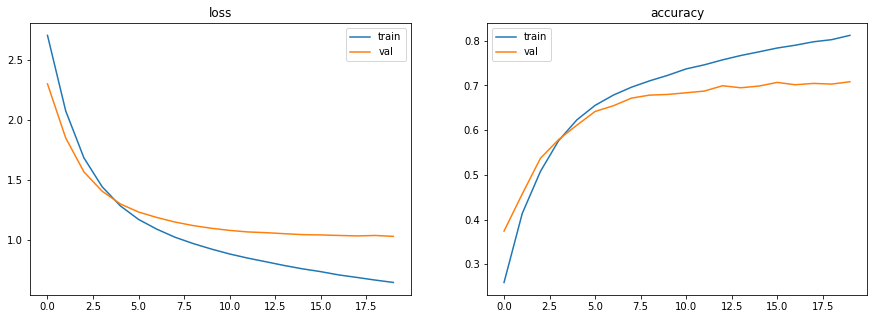

In [29]:
## TODO 4.4: visualize peformance on train , validation set
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.arange(len(train_object_losses)), train_object_losses)
plt.plot(np.arange(len(val_object_losses)), val_object_losses)
plt.legend(['train', 'val'])
plt.title('loss')
plt.subplot(122)
plt.plot(np.arange(len(train_object_accs)), train_object_accs)
plt.plot(np.arange(len(val_object_accs)), val_object_accs)
plt.legend(['train', 'val'])
plt.title('accuracy')
plt.show()

In [30]:
## TODO 4.5: evalaute on test set  
test_preds = []
model_object.eval() 
for inputs in test_object_dataloader: 
  inputs = inputs.to(device)
  with torch.no_grad(): 
    pred = model_object(inputs)
    test_preds.append(pred)

test_preds = torch.cat(test_preds)
test_targets = torch.LongTensor(ys_test[:,1])
test_acc = categorical_accuracy(test_preds, test_targets)
test_f1 = categorical_f1(test_preds, test_targets)
print(f"test accuracy: {test_acc}")
print(f"test f1      : {test_f1}")

test accuracy: 0.7079910380881255
test f1      : 0.6995553751847722


## #TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 

The model will have 2 separate output layers one for action classification task and another for object classification task. 

This is a rough sketch of what your model might look like:
![image](https://raw.githubusercontent.com/ekapolc/nlp_course/master/HW5/multitask_sketch.png)

In [31]:
## TODO 5.1: prepare dataloader 
train_dataset = TrueCallCenterDataset(X_train, ys_train) 
val_dataset = TrueCallCenterDataset(X_val, ys_val)
test_dataset = TrueCallCenterDataset(X_test)

num_workers = 2
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False) 
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False) 

In [32]:
## TODO 5.2: setup model 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Model(encoder = Encoder(word_2_idx), classifier_1 = Classifier(unique_action), classifier_2 = Classifier(unique_object)) 
model.to(device) 

optimizer = Adam(model.parameters(), lr=1e-3) 
criterion = CrossEntropyLoss()
print(torchinfo.summary(model))

Layer (type:depth-idx)                   Param #
Model                                    --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    199,728
├─Classifier: 1-2                        --
│    └─Linear: 2-2                       1,568
│    └─Linear: 2-3                       264
├─Classifier: 1-3                        --
│    └─Linear: 2-4                       1,568
│    └─Linear: 2-5                       858
Total params: 203,986
Trainable params: 203,986
Non-trainable params: 0


In [33]:
## TODO 4.3: training loop
num_epochs = 20

train_losses = [] 
train_accs_0 = [] 
train_accs_1 = [] 

val_losses = [] 
val_accs_0 = [] 
val_accs_1 = [] 

for epoch in range(1, num_epochs+1): 

  train_minibatch_losses = []

  train_preds_0 = []
  train_preds_1 = []
  train_targets_0 = []
  train_targets_1 = []

  model.train() 
  for inputs, targets in tqdm(train_dataloader):
    optimizer.zero_grad() 

    inputs, targets = inputs.to(device), targets.to(device)

    preds = model(inputs)
    pred_0 = preds[0]
    pred_1 = preds[1]
    
    target_0 = targets[:,:,0]
    target_1 = targets[:,:,1]
    target_0 = target_0.reshape(-1)
    target_1 = target_1.reshape(-1)

    loss = criterion(pred_0, target_0) + criterion(pred_1, target_1) 

    train_minibatch_losses.append(loss.item())

    train_preds_0.append(pred_0)
    train_preds_1.append(pred_1)
    train_targets_0.append(target_0)
    train_targets_1.append(target_1)
    
    loss.backward() 
    optimizer.step()

  val_minibatch_losses = []

  val_preds_0 = []
  val_preds_1 = []
  val_targets_0 = []
  val_targets_1 = []

  model.eval() 
  for inputs, vals in tqdm(val_dataloader): 
    inputs, vals = inputs.to(device), vals.to(device)
    with torch.no_grad(): 
      preds = model(inputs)
      pred_0 = preds[0]
      pred_1 = preds[1]
      
      val_0 = vals[:,:,0]
      val_1 = vals[:,:,1]
      val_0 = val_0.reshape(-1)
      val_1 = val_1.reshape(-1)
      
      loss = criterion(pred_0, val_0) + criterion(pred_1, val_1) 

      val_minibatch_losses.append(loss.item())

      val_preds_0.append(pred_0)
      val_preds_1.append(pred_1)
      val_targets_0.append(val_0)
      val_targets_1.append(val_1)
      
  train_preds_0 = torch.cat(train_preds_0)
  train_preds_1 = torch.cat(train_preds_1)
  train_targets_0 = torch.cat(train_targets_0)
  train_targets_1 = torch.cat(train_targets_1)

  val_preds_0 = torch.cat(val_preds_0)
  val_preds_1 = torch.cat(val_preds_1)
  val_targets_0 = torch.cat(val_targets_0)
  val_targets_1 = torch.cat(val_targets_1)

  train_losses.append(np.mean(train_minibatch_losses))
  train_accs_0.append(categorical_accuracy(train_preds_0, train_targets_0))
  train_accs_1.append(categorical_accuracy(train_preds_1, train_targets_1))
  val_losses.append(np.mean(val_minibatch_losses))
  val_accs_0.append(categorical_accuracy(val_preds_0, val_targets_0))
  val_accs_1.append(categorical_accuracy(val_preds_1, val_targets_1))

  print(f' \n\
    epoch = {epoch:02d},\
    training loss   = {train_object_losses[-1]:.3f}, \
    training acc_0    = {train_accs_0[-1]:.3f}, \
    training acc_1    = {train_accs_1[-1]:.3f}, \
    validation loss = {val_object_losses[-1]:.3f}, \
    validation acc_0  = {val_accs_0[-1]:.3f}, \
    validation acc_1  = {val_accs_1[-1]:.3f}')

  0%|          | 0/168 [00:00<?, ?it/s]<ipython-input-16-de8b8cdf41d7>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  torch.LongTensor([self.labels[idx]])
100%|██████████| 21/21 [00:00<00:00, 322.05it/s]


 
    epoch = 01,    training loss   = 0.646,     training acc_0    = 0.627,     training acc_1    = 0.250,     validation loss = 1.030,     validation acc_0  = 0.686,     validation acc_1  = 0.358


100%|██████████| 21/21 [00:00<00:00, 345.39it/s]


 
    epoch = 02,    training loss   = 0.646,     training acc_0    = 0.719,     training acc_1    = 0.389,     validation loss = 1.030,     validation acc_0  = 0.753,     validation acc_1  = 0.460


100%|██████████| 21/21 [00:00<00:00, 367.78it/s]


 
    epoch = 03,    training loss   = 0.646,     training acc_0    = 0.775,     training acc_1    = 0.482,     validation loss = 1.030,     validation acc_0  = 0.793,     validation acc_1  = 0.531


100%|██████████| 21/21 [00:00<00:00, 491.43it/s]


 
    epoch = 04,    training loss   = 0.646,     training acc_0    = 0.801,     training acc_1    = 0.548,     validation loss = 1.030,     validation acc_0  = 0.804,     validation acc_1  = 0.568


100%|██████████| 21/21 [00:00<00:00, 466.18it/s]


 
    epoch = 05,    training loss   = 0.646,     training acc_0    = 0.818,     training acc_1    = 0.593,     validation loss = 1.030,     validation acc_0  = 0.814,     validation acc_1  = 0.599


100%|██████████| 21/21 [00:00<00:00, 476.59it/s]


 
    epoch = 06,    training loss   = 0.646,     training acc_0    = 0.830,     training acc_1    = 0.626,     validation loss = 1.030,     validation acc_0  = 0.834,     validation acc_1  = 0.625


100%|██████████| 21/21 [00:00<00:00, 485.43it/s]


 
    epoch = 07,    training loss   = 0.646,     training acc_0    = 0.839,     training acc_1    = 0.652,     validation loss = 1.030,     validation acc_0  = 0.838,     validation acc_1  = 0.628


100%|██████████| 21/21 [00:00<00:00, 488.31it/s]


 
    epoch = 08,    training loss   = 0.646,     training acc_0    = 0.846,     training acc_1    = 0.673,     validation loss = 1.030,     validation acc_0  = 0.834,     validation acc_1  = 0.642


100%|██████████| 21/21 [00:00<00:00, 510.00it/s]


 
    epoch = 09,    training loss   = 0.646,     training acc_0    = 0.853,     training acc_1    = 0.688,     validation loss = 1.030,     validation acc_0  = 0.832,     validation acc_1  = 0.653


100%|██████████| 21/21 [00:00<00:00, 452.54it/s]


 
    epoch = 10,    training loss   = 0.646,     training acc_0    = 0.857,     training acc_1    = 0.702,     validation loss = 1.030,     validation acc_0  = 0.838,     validation acc_1  = 0.656


100%|██████████| 21/21 [00:00<00:00, 497.23it/s]


 
    epoch = 11,    training loss   = 0.646,     training acc_0    = 0.863,     training acc_1    = 0.717,     validation loss = 1.030,     validation acc_0  = 0.839,     validation acc_1  = 0.662


100%|██████████| 21/21 [00:00<00:00, 459.07it/s]


 
    epoch = 12,    training loss   = 0.646,     training acc_0    = 0.868,     training acc_1    = 0.729,     validation loss = 1.030,     validation acc_0  = 0.842,     validation acc_1  = 0.669


100%|██████████| 21/21 [00:00<00:00, 466.84it/s]


 
    epoch = 13,    training loss   = 0.646,     training acc_0    = 0.872,     training acc_1    = 0.737,     validation loss = 1.030,     validation acc_0  = 0.839,     validation acc_1  = 0.673


100%|██████████| 21/21 [00:00<00:00, 514.19it/s]


 
    epoch = 14,    training loss   = 0.646,     training acc_0    = 0.875,     training acc_1    = 0.745,     validation loss = 1.030,     validation acc_0  = 0.846,     validation acc_1  = 0.674


100%|██████████| 21/21 [00:00<00:00, 258.32it/s]


 
    epoch = 15,    training loss   = 0.646,     training acc_0    = 0.878,     training acc_1    = 0.756,     validation loss = 1.030,     validation acc_0  = 0.847,     validation acc_1  = 0.679


100%|██████████| 21/21 [00:00<00:00, 310.38it/s]


 
    epoch = 16,    training loss   = 0.646,     training acc_0    = 0.882,     training acc_1    = 0.765,     validation loss = 1.030,     validation acc_0  = 0.851,     validation acc_1  = 0.684


100%|██████████| 21/21 [00:00<00:00, 437.69it/s]


 
    epoch = 17,    training loss   = 0.646,     training acc_0    = 0.883,     training acc_1    = 0.771,     validation loss = 1.030,     validation acc_0  = 0.848,     validation acc_1  = 0.682


100%|██████████| 21/21 [00:00<00:00, 523.30it/s]


 
    epoch = 18,    training loss   = 0.646,     training acc_0    = 0.886,     training acc_1    = 0.779,     validation loss = 1.030,     validation acc_0  = 0.847,     validation acc_1  = 0.684


100%|██████████| 21/21 [00:00<00:00, 439.11it/s]


 
    epoch = 19,    training loss   = 0.646,     training acc_0    = 0.890,     training acc_1    = 0.784,     validation loss = 1.030,     validation acc_0  = 0.850,     validation acc_1  = 0.681


100%|██████████| 21/21 [00:00<00:00, 486.06it/s]

 
    epoch = 20,    training loss   = 0.646,     training acc_0    = 0.892,     training acc_1    = 0.792,     validation loss = 1.030,     validation acc_0  = 0.850,     validation acc_1  = 0.680


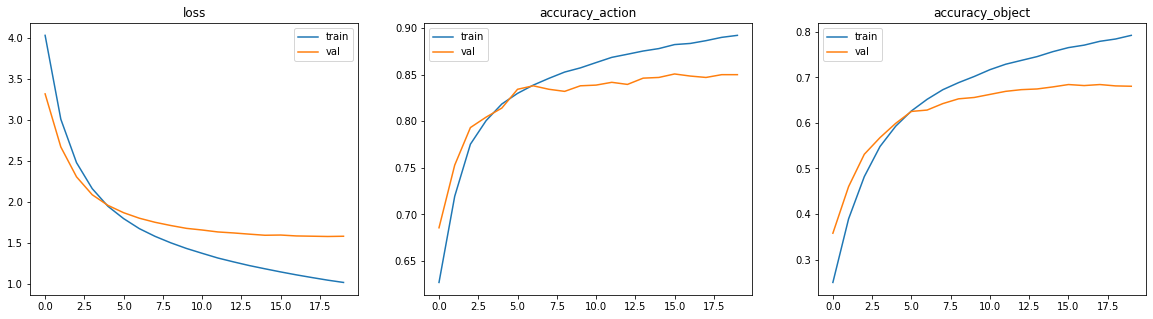

In [34]:
## TODO 5.4: visualize peformance on train , validation set 
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.legend(['train', 'val'])
plt.title('loss')
plt.subplot(132)
plt.plot(np.arange(len(train_accs_0)), train_accs_0)
plt.plot(np.arange(len(val_accs_0)), val_accs_0)
plt.legend(['train', 'val'])
plt.title('accuracy_action')
plt.subplot(133)
plt.plot(np.arange(len(train_accs_1)), train_accs_1)
plt.plot(np.arange(len(val_accs_1)), val_accs_1)
plt.legend(['train', 'val'])
plt.title('accuracy_object')
plt.show()

In [35]:
## TODO 5.5: evalaute on test set  
test_preds_0 = []
test_preds_1 = []
model.eval() 
for inputs in test_action_dataloader: 
  inputs = inputs.to(device)
  with torch.no_grad(): 
    pred = model(inputs)
    test_preds_0.append(pred[0])
    test_preds_1.append(pred[1])
  
test_preds_0 = torch.cat(test_preds_0)
test_preds_1 = torch.cat(test_preds_1)
test_targets_0 = torch.DoubleTensor(ys_test[:,0])
test_targets_1 = torch.DoubleTensor(ys_test[:,1])

test_acc_0 = categorical_accuracy(test_preds_0, test_targets_0)
test_acc_1 = categorical_accuracy(test_preds_1, test_targets_1)
test_f1_0 = categorical_f1(test_preds_0, test_targets_0)
test_f1_1 = categorical_f1(test_preds_1, test_targets_1)

print(f"test accuracy action: {test_acc_0}")
print(f"test accuracy object: {test_acc_1}")
print(f"test f1 action    : {test_f1_0}")
print(f"test f1 object    : {test_f1_1}")

test accuracy action: 0.8483943241224795
test accuracy object: 0.7035100821508589
test f1 action    : 0.8423248984469277
test f1 object    : 0.6962808335391831


## #TODO 6: report the result in each set-up 

**Single Task learning**

Action classification : 
Acc = 0.8461538461538461, f1 = 0.8391541666588023

Object classification : 
Acc = 0.7079910380881255, f1 = 0.6995553751847722

**Multi-task learning**

Action classification : 
Acc =  0.8483943241224795, f1 = 0.8423248984469277

Object classification : 
Acc =  0.7035100821508589, f1 = 0.6962808335391831

## TODO 7: Use pretraining word embedding & handling out of vocabulary words

Pretrained word embeddings can be used to improve the performance of a classification model, as they provide the model better representation of the words. These embeddings can be used to initialize the weights of the neural network model, providing it with a more meaningful starting point for learning especially on smaller datasets.

In this part, we will try to use pretrained word embedding to initialize the word embeddings in this corpus.





In the previous labs, we have always been using a vector of zeros to initialize words for OOVs. However, that is usually not the best method. In this part of the homework, you will try to handle these OOVs better.

**Note :** you can use any pretrained word embedding.

Repeat the model in TODO 5 with pretrained word embedding. Use a better initialization than a vector of zeroes.

Here are some ideas:

1.   [average](https://nlp.stanford.edu/~johnhew/vocab-expansion.html)
2.   [Using character n-grams from FastText](https://fasttext.cc/docs/en/unsupervised-tutorial.html)
3.   [Use a character LSTM model](https://link.springer.com/chapter/10.1007/978-3-030-18305-9_60)

In [ ]:
!wget https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
!unzip resources.zip

In [43]:
from embeddings import emb_reader # load emb_reader.py from PATH
pretrained_embeddings = emb_reader.get_embeddings()

In [38]:
## TODO 7.2: how to handle out of vocab

# Use average embedding vector (64, )

average_vector = np.zeros(64)
for w in pretrained_embeddings:
  if w!='UNK':
    average_vector += pretrained_embeddings[w]
average_vector /= len(pretrained_embeddings)-1 # ignore 'UNK'

pretrained_embeddings_weight = [pretrained_embeddings['PAD']] + [ pretrained_embeddings[idx_2_word[idx]]
                                if idx_2_word[idx] in pretrained_embeddings
                                else average_vector
                                for idx in idx_2_word
                                ][:-1] # ignore 'UNK'
pretrained_embeddings_weight = torch.Tensor(pretrained_embeddings_weight)

print('Embedding shape            ', model.encoder.embed.weight.size())
print('Vacab size                 ', len(word_2_idx))
print('Pretrained embedding shape ', pretrained_embeddings_weight.size())

Embedding shape             torch.Size([4161, 48])
Vacab size                  4161
Pretrained embedding shape  torch.Size([4161, 64])


In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_pretrained = Model(encoder = Encoder(word_2_idx, embedding_dim=64,  _weight=pretrained_embeddings_weight),
                         classifier_1 = Classifier(unique_action, embedding_dim=64),
                         classifier_2 = Classifier(unique_object, embedding_dim=64))
model_pretrained.to(device) 

optimizer = Adam(model_pretrained.parameters(), lr=1e-3) 
criterion = CrossEntropyLoss()
print(torchinfo.summary(model_pretrained))

Layer (type:depth-idx)                   Param #
Model                                    --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    266,304
├─Classifier: 1-2                        --
│    └─Linear: 2-2                       2,080
│    └─Linear: 2-3                       264
├─Classifier: 1-3                        --
│    └─Linear: 2-4                       2,080
│    └─Linear: 2-5                       858
Total params: 271,586
Trainable params: 271,586
Non-trainable params: 0


In [40]:
num_epochs = 20

train_losses = [] 
train_accs_0 = [] 
train_accs_1 = [] 

val_losses = [] 
val_accs_0 = [] 
val_accs_1 = [] 

for epoch in range(1, num_epochs+1): 

  train_minibatch_losses = []

  train_preds_0 = []
  train_preds_1 = []
  train_targets_0 = []
  train_targets_1 = []

  model_pretrained.train() 
  for inputs, targets in tqdm(train_dataloader):
    optimizer.zero_grad() 

    inputs, targets = inputs.to(device), targets.to(device)

    preds = model_pretrained(inputs)
    pred_0 = preds[0]
    pred_1 = preds[1]
    
    target_0 = targets[:,:,0]
    target_1 = targets[:,:,1]
    target_0 = target_0.reshape(-1)
    target_1 = target_1.reshape(-1)

    loss = criterion(pred_0, target_0) + criterion(pred_1, target_1) 

    train_minibatch_losses.append(loss.item())

    train_preds_0.append(pred_0)
    train_preds_1.append(pred_1)
    train_targets_0.append(target_0)
    train_targets_1.append(target_1)
    
    loss.backward() 
    optimizer.step()

  val_minibatch_losses = []

  val_preds_0 = []
  val_preds_1 = []
  val_targets_0 = []
  val_targets_1 = []

  model_pretrained.eval() 
  for inputs, vals in tqdm(val_dataloader): 
    inputs, vals = inputs.to(device), vals.to(device)
    with torch.no_grad(): 
      preds = model_pretrained(inputs)
      pred_0 = preds[0]
      pred_1 = preds[1]
      
      val_0 = vals[:,:,0]
      val_1 = vals[:,:,1]
      val_0 = val_0.reshape(-1)
      val_1 = val_1.reshape(-1)
      
      loss = criterion(pred_0, val_0) + criterion(pred_1, val_1) 

      val_minibatch_losses.append(loss.item())

      val_preds_0.append(pred_0)
      val_preds_1.append(pred_1)
      val_targets_0.append(val_0)
      val_targets_1.append(val_1)
      
  train_preds_0 = torch.cat(train_preds_0)
  train_preds_1 = torch.cat(train_preds_1)
  train_targets_0 = torch.cat(train_targets_0)
  train_targets_1 = torch.cat(train_targets_1)

  val_preds_0 = torch.cat(val_preds_0)
  val_preds_1 = torch.cat(val_preds_1)
  val_targets_0 = torch.cat(val_targets_0)
  val_targets_1 = torch.cat(val_targets_1)

  train_losses.append(np.mean(train_minibatch_losses))
  train_accs_0.append(categorical_accuracy(train_preds_0, train_targets_0))
  train_accs_1.append(categorical_accuracy(train_preds_1, train_targets_1))
  val_losses.append(np.mean(val_minibatch_losses))
  val_accs_0.append(categorical_accuracy(val_preds_0, val_targets_0))
  val_accs_1.append(categorical_accuracy(val_preds_1, val_targets_1))

  print(f' \n\
    epoch = {epoch:02d},\
    training loss   = {train_object_losses[-1]:.3f}, \
    training acc_0    = {train_accs_0[-1]:.3f}, \
    training acc_1    = {train_accs_1[-1]:.3f}, \
    validation loss = {val_object_losses[-1]:.3f}, \
    validation acc_0  = {val_accs_0[-1]:.3f}, \
    validation acc_1  = {val_accs_1[-1]:.3f}')

100%|██████████| 21/21 [00:00<00:00, 355.62it/s]


 
    epoch = 01,    training loss   = 0.646,     training acc_0    = 0.589,     training acc_1    = 0.150,     validation loss = 1.030,     validation acc_0  = 0.647,     validation acc_1  = 0.162


100%|██████████| 21/21 [00:00<00:00, 399.91it/s]


 
    epoch = 02,    training loss   = 0.646,     training acc_0    = 0.647,     training acc_1    = 0.160,     validation loss = 1.030,     validation acc_0  = 0.647,     validation acc_1  = 0.162


100%|██████████| 21/21 [00:00<00:00, 330.30it/s]


 
    epoch = 03,    training loss   = 0.646,     training acc_0    = 0.647,     training acc_1    = 0.174,     validation loss = 1.030,     validation acc_0  = 0.647,     validation acc_1  = 0.181


100%|██████████| 21/21 [00:00<00:00, 357.56it/s]


 
    epoch = 04,    training loss   = 0.646,     training acc_0    = 0.647,     training acc_1    = 0.212,     validation loss = 1.030,     validation acc_0  = 0.650,     validation acc_1  = 0.259


100%|██████████| 21/21 [00:00<00:00, 384.07it/s]


 
    epoch = 05,    training loss   = 0.646,     training acc_0    = 0.666,     training acc_1    = 0.256,     validation loss = 1.030,     validation acc_0  = 0.708,     validation acc_1  = 0.289


100%|██████████| 21/21 [00:00<00:00, 380.79it/s]


 
    epoch = 06,    training loss   = 0.646,     training acc_0    = 0.713,     training acc_1    = 0.297,     validation loss = 1.030,     validation acc_0  = 0.727,     validation acc_1  = 0.317


100%|██████████| 21/21 [00:00<00:00, 417.22it/s]


 
    epoch = 07,    training loss   = 0.646,     training acc_0    = 0.732,     training acc_1    = 0.329,     validation loss = 1.030,     validation acc_0  = 0.745,     validation acc_1  = 0.355


100%|██████████| 21/21 [00:00<00:00, 225.16it/s]


 
    epoch = 08,    training loss   = 0.646,     training acc_0    = 0.751,     training acc_1    = 0.373,     validation loss = 1.030,     validation acc_0  = 0.762,     validation acc_1  = 0.399


100%|██████████| 21/21 [00:00<00:00, 274.67it/s]


 
    epoch = 09,    training loss   = 0.646,     training acc_0    = 0.777,     training acc_1    = 0.420,     validation loss = 1.030,     validation acc_0  = 0.784,     validation acc_1  = 0.452


100%|██████████| 21/21 [00:00<00:00, 379.12it/s]


 
    epoch = 10,    training loss   = 0.646,     training acc_0    = 0.787,     training acc_1    = 0.468,     validation loss = 1.030,     validation acc_0  = 0.787,     validation acc_1  = 0.475


100%|██████████| 21/21 [00:00<00:00, 336.59it/s]


 
    epoch = 11,    training loss   = 0.646,     training acc_0    = 0.794,     training acc_1    = 0.506,     validation loss = 1.030,     validation acc_0  = 0.789,     validation acc_1  = 0.515


100%|██████████| 21/21 [00:00<00:00, 385.98it/s]


 
    epoch = 12,    training loss   = 0.646,     training acc_0    = 0.801,     training acc_1    = 0.536,     validation loss = 1.030,     validation acc_0  = 0.787,     validation acc_1  = 0.538


100%|██████████| 21/21 [00:00<00:00, 384.42it/s]


 
    epoch = 13,    training loss   = 0.646,     training acc_0    = 0.805,     training acc_1    = 0.559,     validation loss = 1.030,     validation acc_0  = 0.790,     validation acc_1  = 0.553


100%|██████████| 21/21 [00:00<00:00, 370.23it/s]


 
    epoch = 14,    training loss   = 0.646,     training acc_0    = 0.812,     training acc_1    = 0.577,     validation loss = 1.030,     validation acc_0  = 0.793,     validation acc_1  = 0.565


100%|██████████| 21/21 [00:00<00:00, 408.68it/s]


 
    epoch = 15,    training loss   = 0.646,     training acc_0    = 0.815,     training acc_1    = 0.597,     validation loss = 1.030,     validation acc_0  = 0.797,     validation acc_1  = 0.582


100%|██████████| 21/21 [00:00<00:00, 408.02it/s]


 
    epoch = 16,    training loss   = 0.646,     training acc_0    = 0.819,     training acc_1    = 0.615,     validation loss = 1.030,     validation acc_0  = 0.800,     validation acc_1  = 0.588


100%|██████████| 21/21 [00:00<00:00, 345.41it/s]


 
    epoch = 17,    training loss   = 0.646,     training acc_0    = 0.827,     training acc_1    = 0.629,     validation loss = 1.030,     validation acc_0  = 0.804,     validation acc_1  = 0.598


100%|██████████| 21/21 [00:00<00:00, 327.39it/s]


 
    epoch = 18,    training loss   = 0.646,     training acc_0    = 0.830,     training acc_1    = 0.641,     validation loss = 1.030,     validation acc_0  = 0.810,     validation acc_1  = 0.606


100%|██████████| 21/21 [00:00<00:00, 416.53it/s]


 
    epoch = 19,    training loss   = 0.646,     training acc_0    = 0.837,     training acc_1    = 0.657,     validation loss = 1.030,     validation acc_0  = 0.809,     validation acc_1  = 0.613


100%|██████████| 21/21 [00:00<00:00, 184.72it/s]

 
    epoch = 20,    training loss   = 0.646,     training acc_0    = 0.842,     training acc_1    = 0.669,     validation loss = 1.030,     validation acc_0  = 0.824,     validation acc_1  = 0.618


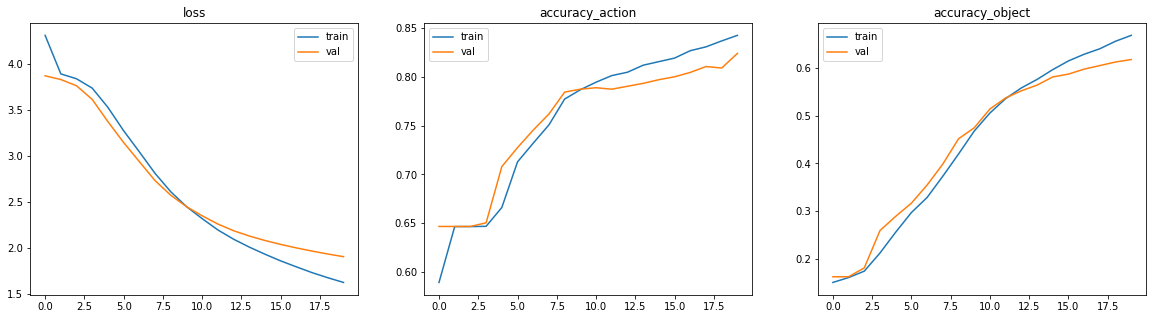

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.legend(['train', 'val'])
plt.title('loss')
plt.subplot(132)
plt.plot(np.arange(len(train_accs_0)), train_accs_0)
plt.plot(np.arange(len(val_accs_0)), val_accs_0)
plt.legend(['train', 'val'])
plt.title('accuracy_action')
plt.subplot(133)
plt.plot(np.arange(len(train_accs_1)), train_accs_1)
plt.plot(np.arange(len(val_accs_1)), val_accs_1)
plt.legend(['train', 'val'])
plt.title('accuracy_object')
plt.show()

In [42]:
test_preds_0 = []
test_preds_1 = []
model_pretrained.eval() 
for inputs in test_action_dataloader: 
  inputs = inputs.to(device)
  with torch.no_grad(): 
    pred = model_pretrained(inputs)
    test_preds_0.append(pred[0])
    test_preds_1.append(pred[1])
  
test_preds_0 = torch.cat(test_preds_0)
test_preds_1 = torch.cat(test_preds_1)
test_targets_0 = torch.DoubleTensor(ys_test[:,0])
test_targets_1 = torch.DoubleTensor(ys_test[:,1])

test_acc_0 = categorical_accuracy(test_preds_0, test_targets_0)
test_acc_1 = categorical_accuracy(test_preds_1, test_targets_1)
test_f1_0 = categorical_f1(test_preds_0, test_targets_0)
test_f1_1 = categorical_f1(test_preds_1, test_targets_1)

print(f"test accuracy action: {test_acc_0}")
print(f"test accuracy object: {test_acc_1}")
print(f"test f1 action    : {test_f1_0}")
print(f"test f1 object    : {test_f1_1}")

test accuracy action: 0.8162808065720687
test accuracy object: 0.6392830470500374
test f1 action    : 0.7964523837606332
test f1 object    : 0.6043285439861027


Describe what pretrained word embedding you used, and how you handle OOVs.

**ANS** TODO 7.3
We use embedding from POS Tagging assingment and we handle OOVs using average embedding vector